# Behavior Test (Insertion, Deletion, Replacement) Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [5]:
filenames = ['_'.join(["ednet_small",i,j]) + ".pkl" for i in ["insertion"] for j in ["saint", "sakt"]]

In [11]:
filenames # files in notion

['ednet_small_insertion_saint.pkl', 'ednet_small_insertion_sakt.pkl']

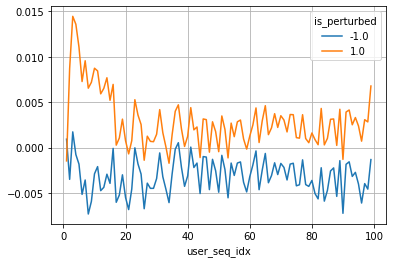

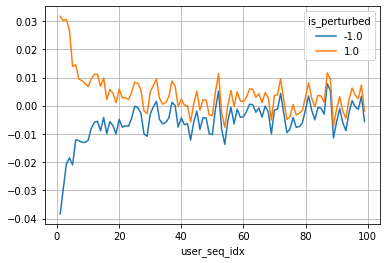

In [13]:
result_dict = {}
for fn in filenames:
    with open(fn, 'rb') as file:
        result_dict[fn] = pickle.load(file)
    x = result_dict[fn]
    x['user_seq_idx'] = np.nan
    x = x.loc[x['is_perturbed'] != 0]
    for (uid, dir), df in x.groupby(['user_id', 'is_perturbed']):
        x.loc[df.index, 'user_seq_idx'] = [x+1 for x in range(df.shape[0])]
    x.set_index(['user_id', 'is_perturbed', 'user_seq_idx'], drop=True)['model_diff'].unstack('user_seq_idx').groupby('is_perturbed').mean().T.iloc[:-1].plot(grid=True)
    plt.savefig(fn.replace('.pkl', '_idx_impact.png'))
    # plt.close('all')

In [8]:
threshold = 0

for fn, df in result_dict.items():
    corr_df = df.loc[df['is_perturbed'] == 1]
    incorr_df = df.loc[df['is_perturbed'] == -1]
    corr_testpass = (corr_df['model_diff'] >= - threshold).values.tolist()
    incorr_testpass = (incorr_df['model_diff'] <= threshold).values.tolist()
    print(fn)
    print(corr_testpass.count(True), '|', corr_testpass.count(False), '->', corr_testpass.count(True)/len(corr_testpass))
    print(incorr_testpass.count(True), '|', incorr_testpass.count(False), '->', incorr_testpass.count(True)/len(incorr_testpass))
    print((corr_testpass.count(True)+incorr_testpass.count(True)) / (len(corr_df) + len(incorr_df)))
    print()

ednet_small_insertion_saint.pkl
10270 | 6981 -> 0.5953278070836473
9905 | 7346 -> 0.5741696133557475
0.5847487102196974

ednet_small_insertion_sakt.pkl
12430 | 4821 -> 0.7205379398295751
12801 | 4450 -> 0.7420439394817692
0.7312909396556722



## Model Summary

DKT original test auc : 0.8278944242188684

SAINT original test auc : 0.847428944098048

test pass probability (threshold=0.0)

| model | test AUC | insertion | deletion | replacement |
| :---: | -------: | --------: | -------: | ----------: |
| DKT   | 0.8279   | 48.88%    | 48.34%   | 48.45%      |
| SAINT | 0.8474   | 50.63%    | 54.06%   | 54.11%      |

## Detailed Analysis

### Impact upon steps(num of interactions)

spanish_deletion_saint.csv


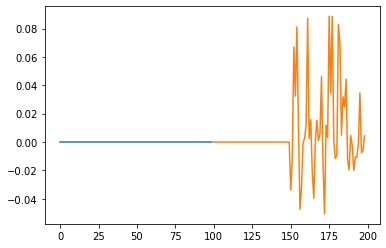

spanish_deletion_sakt.csv


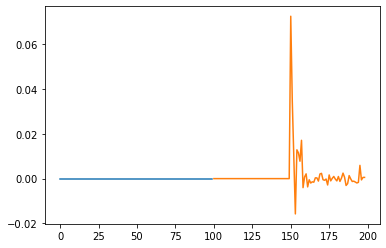

In [46]:
all_results = []
for fn, df in result_dict.items():
    user_group_df = df.groupby(['orig_user_id'])
    new_df_list = []
    sample = True
    print(fn)
    for name, group in user_group_df:
        start_idx = group.iloc[0]['orig_idx']
        group.loc[:, 'new_idx'] = group['orig_idx'] - start_idx
        if sample:
            group.groupby('user_id')['model_diff'].plot()
            plt.show()
            if False:
                corr_df = group.loc[group['is_perturbed'] == 1]
                incorr_df = group.loc[group['is_perturbed'] == -1]
                sample_corr = (corr_df['model_diff']).values.tolist()
                sample_incorr = (incorr_df['model_diff']).values.tolist()
                if sample_corr:
                    plt.plot(sample_corr)
                    plt.show()
                if sample_incorr:
                    plt.plot(sample_incorr)
                    plt.show()
            sample = False
        new_df_list.append(group)
    new_df = pd.concat(new_df_list, axis=0).reset_index(drop=True)
    all_results.append(new_df)

In [40]:
df.groupby('user_id').head()


,new_idx,orig_idx,user_id,item_id,timestamp,correct,skill_id,orig_user_id,is_perturbed,model_pred,testpass,model_diff,all
0,0,0,0,7.0,0.0,0.0,6.0,8.0,0.0,0.459971,NaN,0.0,all
1,1,1,0,23.0,0.0,0.0,8.0,8.0,0.0,0.302915,NaN,0.0,all
2,2,2,0,31.0,0.0,0.0,1.0,8.0,0.0,0.217103,NaN,0.0,all
3,3,3,0,22.0,0.0,1.0,15.0,8.0,0.0,0.130738,NaN,0.0,all
4,4,4,0,46.0,0.0,0.0,21.0,8.0,0.0,0.080233,NaN,0.0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7264,7264,3600,73,73.0,0.0,0.0,12.0,180.0,1.0,0.459971,True,0.0,all
7265,7265,3601,73,97.0,0.0,1.0,6.0,180.0,1.0,0.284865,True,0.0,all
7266,7266,3602,73,88.0,0.0,0.0,20.0,180.0,1.0,0.452073,True,0.0,all
7267,7267,3603,73,31.0,0.0,0.0,1.0,180.0,1.0,0.418310,True,0.0,all


### Original model prediction analysis

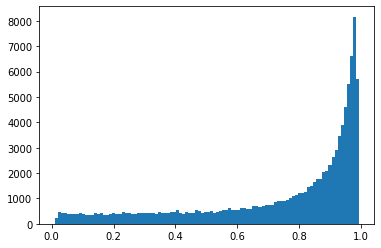

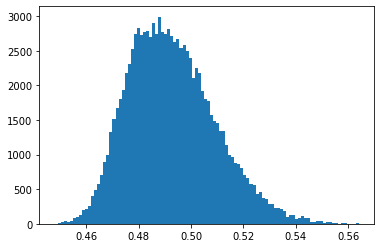

In [29]:
for df in result_list[:2]:
    orig_probs = df['orig_prob'].values.tolist()
    plt.hist(orig_probs, bins=100)
    plt.show()